In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY"
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

 99% 2.35G/2.37G [00:27<00:00, 94.8MB/s]
100% 2.37G/2.37G [00:27<00:00, 91.9MB/s]


In [0]:
import zipfile
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from PIL import Image
import tensorflow as tf
import os
import shutil
from random import shuffle

In [0]:
zfile = zipfile.ZipFile('weed-detection-in-soybean-crops.zip')
zfile.extractall()

In [0]:
def copySourceToDest(source_list, source_path, destination_path):
  """
  This function takes images source list, source path string, destination path string
  and copy the image from source path to destination path
  """
  for image in source_list:
    shutil.copy('{}{}'.format(source_path,image), destination_path)


In [0]:
def split_test_train(datalist):
  list_len = len(datalist)
  train_len = list_len*0.8
  return datalist[0 : int(train_len)], datalist[int(train_len) : ]

In [0]:
# <--- Create directories --->
shutil.rmtree('weed_dataset')
os.mkdir('weed_dataset')
os.mkdir('weed_dataset/training_set')
os.mkdir('weed_dataset/training_set/broadleaf')
os.mkdir('weed_dataset/training_set/grass')
os.mkdir('weed_dataset/training_set/soil')
os.mkdir('weed_dataset/training_set/soybean')


os.mkdir('weed_dataset/test_set')
os.mkdir('weed_dataset/test_set/broadleaf')
os.mkdir('weed_dataset/test_set/grass')
os.mkdir('weed_dataset/test_set/soil')
os.mkdir('weed_dataset/test_set/soybean')
# <--- Create directories --->


In [0]:
broadleaf_list = os.listdir('dataset/broadleaf/')
shuffle(broadleaf_list)
broad_train, broad_test = split_test_train(broadleaf_list)

grass_list = os.listdir('dataset/grass/')
shuffle(grass_list)
grass_train, grass_test = split_test_train(grass_list)

soil_list = os.listdir('dataset/soil/')
shuffle(soil_list)
soil_train, soil_test = split_test_train(soil_list)

soybean_list = os.listdir('dataset/soybean/')
shuffle(soybean_list)
soy_train, soy_test = split_test_train(soybean_list)

In [0]:
copySourceToDest(broad_train, 'dataset/broadleaf/', 
                 'weed_dataset/training_set/broadleaf/')
copySourceToDest(broad_test, 'dataset/broadleaf/', 
                 'weed_dataset/test_set/broadleaf/')

copySourceToDest(grass_train, 'dataset/grass/', 
                 'weed_dataset/training_set/grass/')
copySourceToDest(grass_test, 'dataset/grass/', 
                 'weed_dataset/test_set/grass/')

copySourceToDest(soil_train, 'dataset/soil/', 
                 'weed_dataset/training_set/soil/')
copySourceToDest(soil_test, 'dataset/soil/', 
                 'weed_dataset/test_set/soil/')

copySourceToDest(soy_train, 'dataset/soybean/', 
                 'weed_dataset/training_set/soybean/')
copySourceToDest(soy_test, 'dataset/soybean/', 
                 'weed_dataset/test_set/soybean/')


In [0]:
base_model= InceptionV3(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(512,activation='relu')(x) 
preds=Dense(4,activation='softmax')(x) #final layer with softmax activation

for layer in base_model.layers:
    layer.trainable = False
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    'weed_dataset/training_set/',
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    'weed_dataset/test_set/',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 12267 images belonging to 4 classes.
Found 3069 images belonging to 4 classes.


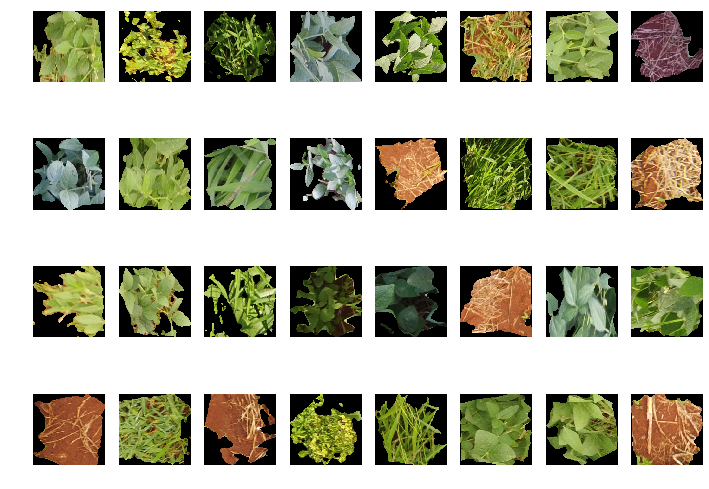

In [29]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [30]:
EPOCHS = 10
BATCH_SIZE = 16
STEPS_PER_EPOCH = 1000
VALIDATION_STEPS = 64

MODEL_FILE = 'weed_model.h5'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
1000/1000 [==============================] - 359s 359ms/step - loss: 0.1854 - acc: 0.9346 - val_loss: 0.3577 - val_acc: 0.9009
Epoch 2/10
1000/1000 [==============================] - 344s 344ms/step - loss: 0.1113 - acc: 0.9613 - val_loss: 0.2936 - val_acc: 0.9042
Epoch 3/10
1000/1000 [==============================] - 343s 343ms/step - loss: 0.0985 - acc: 0.9653 - val_loss: 0.3300 - val_acc: 0.8973
Epoch 4/10
1000/1000 [==============================] - 343s 343ms/step - loss: 0.0928 - acc: 0.9673 - val_loss: 0.2632 - val_acc: 0.9219
Epoch 5/10
1000/1000 [==============================] - 342s 342ms/step - loss: 0.0825 - acc: 0.9727 - val_loss: 0.3417 - val_acc: 0.9115
Epoch 6/10
1000/1000 [==============================] - 343s 343ms/step - loss: 0.0731 - acc: 0.9756 - val_loss: 0.2458 - val_acc: 0.9237
Epoch 7/10
1000/1000 [==============================] - 343s 343ms/step - lo

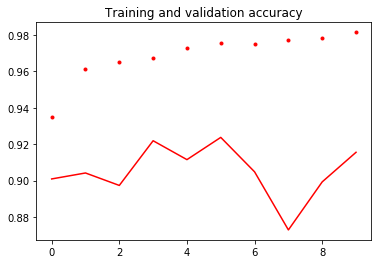

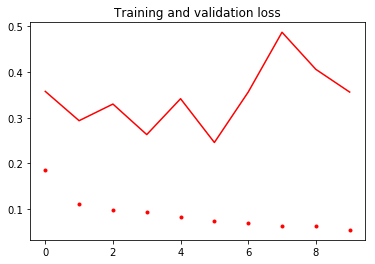

In [31]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [0]:
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model
import operator


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

    

def print_preds(img, preds):
  plt.imshow(np.asarray(img))
  
  # Example data
  pred_dict = {'broadleaf':preds[0],'grass':preds[1],'soil':preds[2],'soybean':preds[3]}
  output = max(pred_dict.items(), key=operator.itemgetter(1))[0]
  print('The predicted image is of type {}'.format(output))

In [0]:
# loading the model
model = load_model(MODEL_FILE)

In [0]:
def predict_output(filepath):
  """
    Predicts the output for the given image.
    Args:
        filepath: file path for the image to be predicted
    Returns:
        preds: the predicted disease with its probability 
  """
  img = image.load_img(filepath, target_size=(299, 299))
  preds = predict(model, img)
  print_preds(np.asarray(img), preds)


The predicted image is of type broadleaf


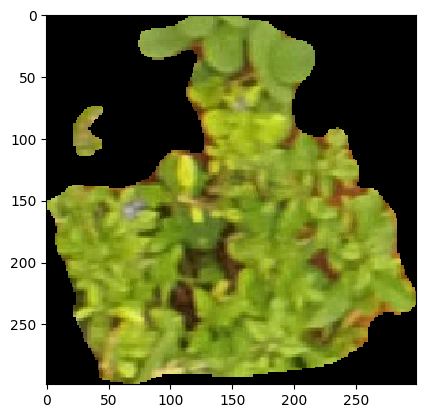

In [84]:
predict_output('weed_dataset/test_set/broadleaf/1.tif')

The predicted image is of type grass


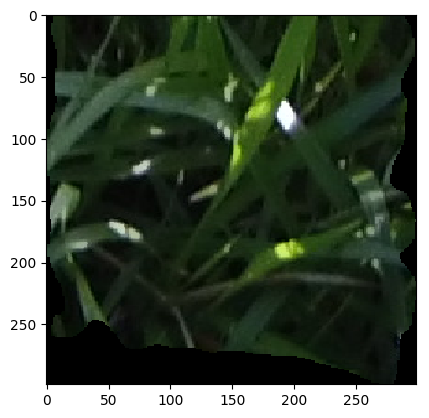

In [85]:
predict_output('weed_dataset/test_set/grass/100.tif')

The predicted image is of type soil


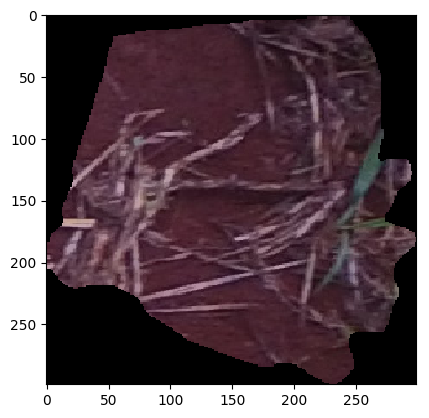

The predicted image is of type soil


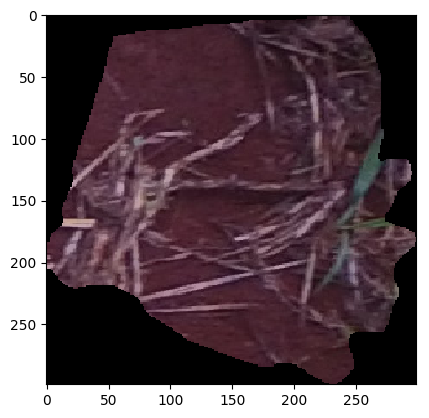

In [88]:
predict_output('weed_dataset/test_set/soil/1000.tif')

The predicted image is of type soybean


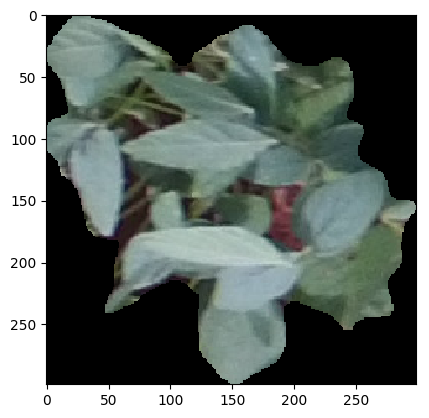

The predicted image is of type soybean


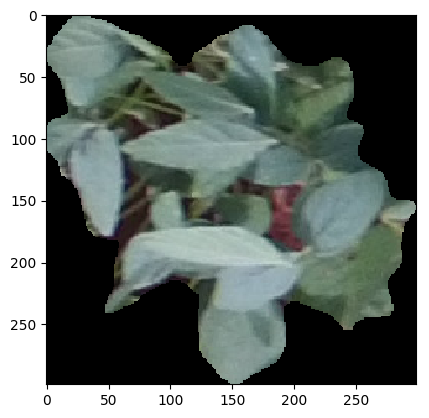

In [89]:
predict_output('weed_dataset/test_set/soybean/1009.tif')